<a href="https://colab.research.google.com/github/jhiltonsantos/ADS-Estatistica-IFPI/blob/master/AnaliseAcidentesAereosBR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise de dados de Acidentes Aereos (Período 2008-2018(Maio))**

## Objetivos
  **Identificar, através dos anos, quais os principais tipos de acidentes em cada região do país,e observar as rotas com maiores números de ocorrências.Para isso iremos levantar:**<br>

---


  <br>•Identificar as cidades com maiores ocorrencias e colocar quais os principais tipos de acidentes, se houve óbitos, quais os principais tipos de aeronaves e o segmento;<br>
  <br>• Relação entre os tipos de operação e a classificação da ocorrencia;<br>
  <br>• Classificação por regiões do país;<br>
<br> • Mostrar as ocorrências no país inteiro, depois mostrar as regioẽs de maiores ocorrencias;<br> <br> • Mostrar o numero de acidentes, quantidade de fatais, principais motivos e as principais áreas de atuação.<br>


<br>

---



## Bibliotecas

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from itertools import product
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import folium
import os

from decimal import Decimal
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler


## Funções

In [0]:
def tem_numero(string): # Retornar se string possue numero
  return any(char.isdigit() for char in string)

def remove_repetidos(array): # Remover Elementos Repetidos do Array
    l = []
    for i in array:
        if i not in l:
            l.append(i)
    l.sort()
    return l

def numero_em_cima(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')


## Tratando Dados

### Dados Originais - Opendata AIG Brazil (Centro de Investigação e Prevenção de Acidentes Aeronáuticos - CENIPA)

In [0]:
dados = pd.read_csv('https://raw.githubusercontent.com/jhiltonsantos/ADS-Estatistica-IFPI/master/Projeto%20Final/accidents_table_types_edited.csv')
dados.dataframeName = 'Accidents'
nRow, nCol, = dados.shape
dados.head(2)

,codigo_ocorrencia,ocorrencia_classificacao,ocorrencia_tipo,ocorrencia_dia,ocorrencia_horario,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,aeronave_matricula,aeronave_equipamento,aeronave_fabricante,aeronave_modelo,aeronave_tipo_motor,aeronave_quantidade_motores,aeronave_peso_maximo_decolagem,aeronave_quantidade_assentos,aeronave_ano_fabricacao,aeronave_pais_registro,aeronave_categoria_registro,aeronave_segmento_aviacao,aeronave_origem_voo,aeronave_destino_voo,aeronave_fase_voo,aeronave_tipo_operacao,aeronave_nivel_dano,quantidade_fatalidades,quantidade_fatores_contribuintes,fator_1,fator_2,fator_3,fator_4,fator_5,fator_6,fator_7,fator_8,fator_9,fator_10,fator_11,fator_12,...,fator_49,fator_50,fator_51,fator_52,fator_53,fator_54,fator_55,fator_56,fator_57,fator_58,fator_59,fator_60,fator_61,fator_62,fator_63,fator_64,fator_65,fator_66,fator_67,fator_68,fator_69,fator_70,fator_71,fator_72,fator_73,fator_74,fator_75,fator_76,fator_77,fator_78,fator_79,fator_80,fator_81,fator_82,fator_83,fator_84,fator_85,fator_86,fator_87,dia_extracao
0,201211159478138,ACIDENTE,FALHA DO MOTOR EM VOO,2012-11-15,12:40:00,ABADIA DE GOIAS,GO,BRASIL,****,PPZGV,AVIÃO,IVAN MOLCHAN,GV-2,PISTÃO,1.0,430,2.0,1985.0,BRASIL,PET,EXPERIMENTAL,****,****,MANOBRA,VOO EXPERIMENTAL,SUBSTANCIAL,NaN,0,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,2018-05-06
1,200912289948837,ACIDENTE,PERDA DE CONTROLE EM VOO,2009-12-28,17:30:00,ACEGUA,RS,BRASIL,****,PRSUB,AVIÃO,CESSNA AIRCRAFT,A188B,PISTÃO,1.0,1812,1.0,1973.0,BRASIL,SAE,ESPECIALIZADA,****,****,DECOLAGEM,OPERAÇÃO ESPECIALIZADA,SUBSTANCIAL,1.0,1,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,...,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,SIM,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,NÃO,2018-05-06


### Remover Dados Que Não Serão Manipulados (Fator_*)

In [0]:
remover_fator = []
for i in range(1, len(dados.columns)):
  if tem_numero(dados.columns[i]) == True:
    remover_fator.append(dados.columns[i])

dados.drop(columns=remover_fator, inplace=True)
dados.head(2)

,codigo_ocorrencia,ocorrencia_classificacao,ocorrencia_tipo,ocorrencia_dia,ocorrencia_horario,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,aeronave_matricula,aeronave_equipamento,aeronave_fabricante,aeronave_modelo,aeronave_tipo_motor,aeronave_quantidade_motores,aeronave_peso_maximo_decolagem,aeronave_quantidade_assentos,aeronave_ano_fabricacao,aeronave_pais_registro,aeronave_categoria_registro,aeronave_segmento_aviacao,aeronave_origem_voo,aeronave_destino_voo,aeronave_fase_voo,aeronave_tipo_operacao,aeronave_nivel_dano,quantidade_fatalidades,quantidade_fatores_contribuintes,dia_extracao
0,201211159478138,ACIDENTE,FALHA DO MOTOR EM VOO,2012-11-15,12:40:00,ABADIA DE GOIAS,GO,BRASIL,****,PPZGV,AVIÃO,IVAN MOLCHAN,GV-2,PISTÃO,1.0,430,2.0,1985.0,BRASIL,PET,EXPERIMENTAL,****,****,MANOBRA,VOO EXPERIMENTAL,SUBSTANCIAL,NaN,0,2018-05-06
1,200912289948837,ACIDENTE,PERDA DE CONTROLE EM VOO,2009-12-28,17:30:00,ACEGUA,RS,BRASIL,****,PRSUB,AVIÃO,CESSNA AIRCRAFT,A188B,PISTÃO,1.0,1812,1.0,1973.0,BRASIL,SAE,ESPECIALIZADA,****,****,DECOLAGEM,OPERAÇÃO ESPECIALIZADA,SUBSTANCIAL,1.0,1,2018-05-06


### Adicionando Coluna "ano" aos Dados

In [0]:
data_ocorrencias = []
for i in range(len(dados)):
  data_ocorrencias.append(dados['ocorrencia_dia'][i])

anos_ocorrencias = []
ano = []
for i in range(len(data_ocorrencias)):
  ano.append(data_ocorrencias[i].split('-'))
  anos_ocorrencias.append(ano[i][0])

# Transformar anos para inteiro
anos_int = []
for i in range(len(anos_ocorrencias)):
  anos_int.append(int(anos_ocorrencias[i]))
anos_int

dados['ano'] = anos_int
dados.head(2)

### Dados de Latitude e Longitude (Decimal) dos Estados - IBGE


In [0]:
dados_lat_long = pd.read_csv('https://raw.githubusercontent.com/jhiltonsantos/ADS-Estatistica-IFPI/master/MunicipiosBrasil.csv')
dados_lat_long.head(2)

,ID,LATITUDE,LONGITUDE,Mun/UF,MUNICIPIO,UF,Valor
0,2.0,-10.94,-69.56,ASSIS BRASIL - AC,ASSIS BRASIL,AC,17.842.150.988.839
1,3.0,-11.01,-68.74,BRASILEIA - AC,BRASILEIA,AC,9.337.339.431.323


In [0]:
# Esses Dados já foram inseridos em um novo CSV (DADO PRONTOS)

# Criando colunas latitude e longitude
#dados['latitude'] = -9.42
#dados['longitude'] = -30.89

# Passando valores de base_geo_br.csv para dados
#for i in range(len(dados_lat_long)):
#  for k in range(len(dados)):
#    if (dados['ocorrencia_cidade'][k] == dados_lat_long['MUNICIPIO'][i]) and (dados['ocorrencia_uf'][k] == dados_lat_long['UF'][i]):
#      dados['latitude'][k] = dados_lat_long['LATITUDE'][i]
#      dados['longitude'][k] = dados_lat_long['LONGITUDE'][i]

#export_csv = dados.to_csv(r'drive/My Drive/dados_prontos.csv', index = None, header=True)

### Dados Prontos

In [0]:
dados_prontos = pd.read_csv('https://raw.githubusercontent.com/jhiltonsantos/ADS-Estatistica-IFPI/master/dados_prontos.csv')
dados_prontos.head(2)

,codigo_ocorrencia,ocorrencia_classificacao,ocorrencia_tipo,ocorrencia_dia,ocorrencia_horario,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,aeronave_matricula,aeronave_equipamento,aeronave_fabricante,aeronave_modelo,aeronave_tipo_motor,aeronave_quantidade_motores,aeronave_peso_maximo_decolagem,aeronave_quantidade_assentos,aeronave_ano_fabricacao,aeronave_pais_registro,aeronave_categoria_registro,aeronave_segmento_aviacao,aeronave_origem_voo,aeronave_destino_voo,aeronave_fase_voo,aeronave_tipo_operacao,aeronave_nivel_dano,quantidade_fatalidades,quantidade_fatores_contribuintes,dia_extracao,ano,latitude,longitude
0,201211159478138,ACIDENTE,FALHA DO MOTOR EM VOO,2012-11-15,12:40:00,ABADIA DE GOIAS,GO,BRASIL,****,PPZGV,AVIÃO,IVAN MOLCHAN,GV-2,PISTÃO,1.0,430,2.0,1985.0,BRASIL,PET,EXPERIMENTAL,****,****,MANOBRA,VOO EXPERIMENTAL,SUBSTANCIAL,NaN,0,2018-05-06,2012,-16.75,-49.43
1,200912289948837,ACIDENTE,PERDA DE CONTROLE EM VOO,2009-12-28,17:30:00,ACEGUA,RS,BRASIL,****,PRSUB,AVIÃO,CESSNA AIRCRAFT,A188B,PISTÃO,1.0,1812,1.0,1973.0,BRASIL,SAE,ESPECIALIZADA,****,****,DECOLAGEM,OPERAÇÃO ESPECIALIZADA,SUBSTANCIAL,1.0,1,2018-05-06,2009,-31.87,-54.15


## 1. Ocorrências no País

### Ocorrencias no Mapa

In [0]:
mapa_br = folium.Map(location=[-12, -50],
                 zoom_start = 4, control_scale = True, prefer_canvas=True)


for i in range (0, 5000, 5):
  if dados_prontos['latitude'][i] != -9.42:
    folium.Marker(
        location=[dados_prontos['latitude'][i], dados_prontos['longitude'][i]],
        popup="Codigo da Ocorrencia: "+str(dados_prontos['codigo_ocorrencia'][i])+"<br>"
              +"<br>Estado(UF): "+dados_prontos['ocorrencia_uf'][i]+"<br>"
              +"<br>Cidade:"+dados_prontos['ocorrencia_cidade'][i]+"<br>"
              +"<br>Classificacao da Ocorrencia: "+dados_prontos['ocorrencia_classificacao'][i]+"<br>"
              +"<br>Tipo de Ocorrencia: "+dados_prontos['ocorrencia_tipo'][i]+"<br>"
              +"<br>Data:"+dados_prontos['ocorrencia_dia'][i]+"<br>"
              +"<br>Modelo Aeronave: "+dados_prontos['aeronave_modelo'][i]+"<br>"
              +"<br>Ano Fabricacao Aeronave: "+str(dados_prontos['aeronave_ano_fabricacao'][i])+"<br>"
              ,
        icon=folium.Icon(color='red', icon='info-sign'),
    ).add_to(mapa_br)

mapa_br

### Número de Fatalidades no Período de 2008 à 2018 

In [0]:
cidades = ['RIO DE JANEIRO', 'SAO PAULO', 'BELO HORIZONTE', 'BRASILIA', 'GUARULHOS']
anos = sorted(list(set(dados_prontos['ano'])))
not_null = dados_prontos.dropna()
dic_anos = {i: [int(not_null.loc[not_null['ano'] == ano, 
                             ['quantidade_fatalidades']].loc[not_null['ocorrencia_cidade'] == i, 
                                                             ['quantidade_fatalidades']].sum()) for ano in anos] for i in cidades}
dic_anos['ano'] = anos 
dados_anos = pd.DataFrame(dic_anos)
dados_anos

,RIO DE JANEIRO,SAO PAULO,BELO HORIZONTE,BRASILIA,GUARULHOS,ano
0,4,0,4,0,0,2008
1,0,0,0,0,0,2009
2,6,1,2,0,0,2010
3,3,0,0,0,0,2011
4,4,3,0,0,0,2012
5,0,1,0,0,0,2013
6,2,0,0,2,0,2014
7,0,0,3,0,0,2015
8,4,7,0,0,0,2016
9,0,0,0,0,0,2017


In [0]:
dados_m_anos = pd.DataFrame({'ano': anos, 'mortes': [int(not_null.loc[not_null['ano'] == ano, 
                                                                      ['quantidade_fatalidades']].sum()) for ano in anos]})
dados_m_anos = dados_m_anos.sort_values('mortes')
dados_m_anos

,ano,mortes
10,2018,25
9,2017,52
2,2010,55
0,2008,58
1,2009,63
7,2015,70
6,2014,80
5,2013,94
8,2016,94
3,2011,110


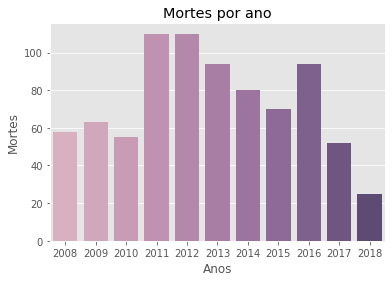

In [0]:
f, ax = plt.subplots()
pallete = sns.cubehelix_palette(11, 3, 0.4, 0.60, 0.8, 0.6)

sns.barplot(dados_m_anos['ano'], dados_m_anos['mortes'], palette=pallete)

ax.set_xlabel('Anos')
ax.set_ylabel("Mortes")
ax.set_title('Mortes por ano')
plt.show()

### Relação de Acidentes x Incidentes

In [0]:
dic_regioes = {'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
                'Norte': ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC'],
                'Centro Oeste': ['MT', 'MS', 'GO'], 
                'Sudeste': ['SP', 'RJ', 'ES', 'MG'],
                'Sul': ['PR', 'RS', 'SC']}
tipos = ['ACIDENTE', 'INCIDENTE', 'INCIDENTE GRAVE']
dic_01 = {i: [ len([k for k in list(dados_prontos.loc[dados_prontos['ocorrencia_classificacao'] == i, ['ocorrencia_uf']]['ocorrencia_uf'])
                    if k in dic_regioes[j]]) for j in dic_regioes.keys()] for i in tipos}

dic_01['tipo'] = list(dic_regioes.keys())
dados_regioes = pd.DataFrame(dic_01)
dados_regioes

,ACIDENTE,INCIDENTE,INCIDENTE GRAVE,tipo
0,163,291,77,Nordeste
1,242,321,92,Norte
2,340,210,80,Centro Oeste
3,568,1405,238,Sudeste
4,353,466,113,Sul


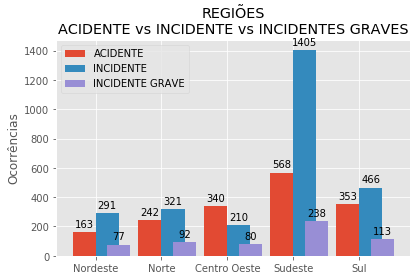

In [0]:
x = np.arange(5)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dados_regioes['ACIDENTE'], width, label='ACIDENTE')
rects2 = ax.bar(x + width/2, dados_regioes['INCIDENTE'], width, label='INCIDENTE')
rects3 = ax.bar(x + width, dados_regioes['INCIDENTE GRAVE'], width, label='INCIDENTE GRAVE')

ax.set_ylabel('Ocorrências')
ax.set_title('REGIÕES\nACIDENTE vs INCIDENTE vs INCIDENTES GRAVES')
ax.set_xticks(x)
ax.set_xticklabels(dados_regioes['tipo'])
ax.legend()

numero_em_cima(rects1, ax)
numero_em_cima(rects2, ax)
numero_em_cima(rects3, ax)

fig.tight_layout()

plt.show()

### Box Plot do Número de Mortes por Ano

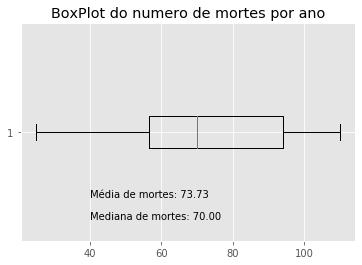

In [0]:
plt.text(40, 0.6, 'Mediana de mortes: %.2f'%(np.median(np.array(dados_m_anos['mortes']))))
plt.text(40, 0.7, 'Média de mortes: %.2f'%(np.mean(np.array(dados_m_anos['mortes']))))
plt.boxplot(dados_m_anos['mortes'], 0, 'rs', 0)
plt.title('BoxPlot do numero de mortes por ano')
plt.show()

### Número do Tipos de Operações que mais ocorrem

In [0]:
tipos_operacao = list(set(dados_prontos['aeronave_tipo_operacao']))
todos_inicidentes = list(dados_prontos.loc[(dados_prontos['ocorrencia_classificacao']) == 'INCIDENTE', ['aeronave_tipo_operacao']]
                         ['aeronave_tipo_operacao'])
qtd_incidentes_tipo = pd.DataFrame({'Tipo': tipos_operacao, 'Incidentes': [todos_inicidentes.count(i) for i in tipos_operacao]})
qtd_incidentes_tipo = qtd_incidentes_tipo.sort_values(['Incidentes'])

In [0]:
todos_acidentes = list(dados_prontos.loc[(dados_prontos['ocorrencia_classificacao']) == 'ACIDENTE', ['aeronave_tipo_operacao']]
                         ['aeronave_tipo_operacao'])
qtd_acidentes_tipo = pd.DataFrame({'Tipo': tipos_operacao, 'Acidentes': [todos_acidentes.count(i) for i in tipos_operacao]})
qtd_acidentes_tipo = qtd_acidentes_tipo.sort_values(['Acidentes'])

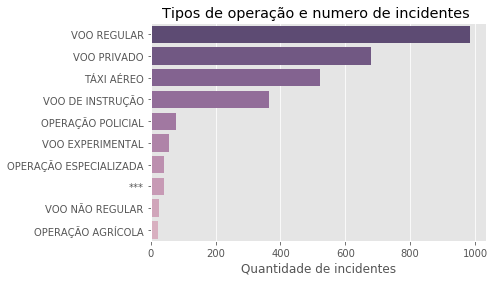

In [0]:
f, ax = plt.subplots()
pallete = sns.cubehelix_palette(10, 3, 0.4, 0.60, 0.8, 0.6)

sns.barplot(qtd_incidentes_tipo['Incidentes'], qtd_incidentes_tipo['Tipo'], palette=pallete)

ax.invert_yaxis()
ax.set_xlabel('Quantidade de incidentes')
ax.set_ylabel("")
ax.set_title('Tipos de operação e numero de incidentes ')

plt.show()

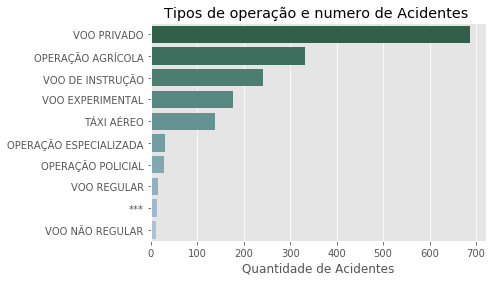

In [0]:
f, ax = plt.subplots()
pallete = sns.cubehelix_palette(10, 5, 0.4, 0.60, 0.8, 0.6)

sns.barplot(qtd_acidentes_tipo['Acidentes'], qtd_acidentes_tipo['Tipo'], palette=pallete)

ax.invert_yaxis()
ax.set_xlabel('Quantidade de Acidentes')
ax.set_ylabel("")
ax.set_title('Tipos de operação e numero de Acidentes ')

plt.show()

## 2. Classificação por Estados

### Acidentes e Incidentes Por Estados

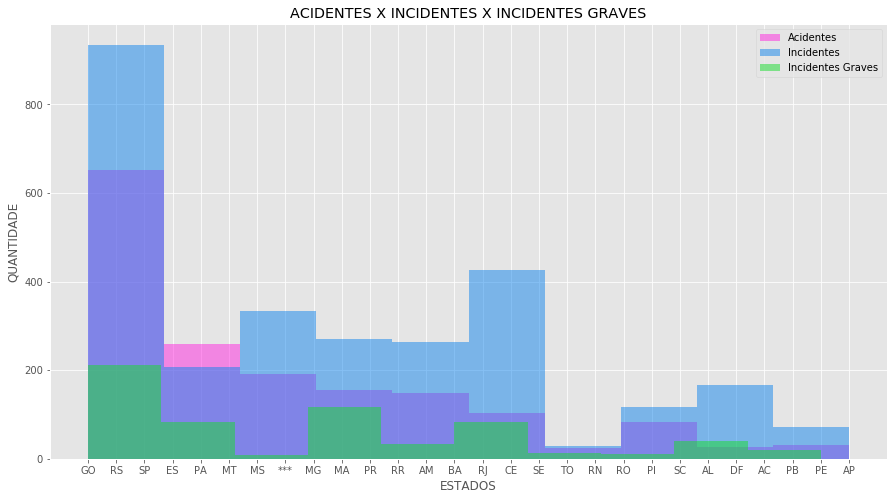

In [0]:
acidente = dados_prontos[dados_prontos.ocorrencia_classificacao == 'ACIDENTE']
incidente = dados_prontos[dados_prontos.ocorrencia_classificacao == 'INCIDENTE']
incidente_grave = dados_prontos[dados_prontos.ocorrencia_classificacao == 'INCIDENTE GRAVE']

#incidente = incidente + incidente_grave
plt.title('ACIDENTES X INCIDENTES X INCIDENTES GRAVES')
plt.xlabel('ESTADOS')
plt.ylabel('QUANTIDADE')

estado_aci = acidente['ocorrencia_uf']
estado_inc = incidente['ocorrencia_uf']
estado_inc_gra = incidente_grave['ocorrencia_uf']

estado_aci.hist(figsize=(15,8), alpha=0.5, label='Acidentes', color='#FF26E1')
estado_inc.hist( figsize=(15,8), alpha=0.5, label='Incidentes', color='#1084EC')
estado_inc_gra.hist( figsize=(15,8), alpha=0.5, label='Incidentes Graves', color='#17DC2C')
plt.legend(loc='upper right')




### Bubble Map com a Quantidade de Ocorrência por Estados 

In [0]:
data = pd.DataFrame ({
    'lat' : [-23.52, -22.9, -19.81, -25.42,  -30.03, -16.67, -1.45, -15.59, -3.1,    -12.97, -27.59,  -15.78,  -20.44,  -8.05,    -3.71,   -20.31,   -2.53,   -9.97,   -10.16,   2.82,   -5.08,   -8.76,  -7.11,    -10.91,   -9.66,    -6.19,    0.03,       -9.42],
    'lon' : [-46.63, -43.2, -43.95, -49.27,  -51.23, -49.25, -48.5, -56.09, -60.02,  -38.51, -48.54,   -47.93, -54.64,  -34.88,   -38.54,  -40.33,   -44.3,  -67.81,   -48.33,  -60.67,  -42.8,   -63.9,  -34.86,   -37.07,   -35.73,   -35.16,   -51.06,     -30.89],
    'name' : ['SP',   'RJ',   'MG',   'PR',   'RS',   'GO',  'PA',  'MT',    'AM',   'BA',    'SC',   'DF',     'MS',    'PE',    'CE',    'ES',      'MA',   'AC',     'TO',   'RR',     'PI',   'RO',   'PB',     'SE',     'AL',     'RN',    'AP',    'AGUAS INTERNACIONAIS'],
    'value' : [1191,  496,    458,    428,    344,    263,   244,   238,     216,    206,      160,    154,     129,     87,       71,      66,       59,     52,       51,     51,       38,      28,     20,      19,       16,       15,       13,         3]
})

In [0]:
map_br = folium.Map(location=[-12, -50],
                 zoom_start = 4, control_scale = True, prefer_canvas=True)


data['value']=data.value.astype(float)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup="<br>ESTADO: "+data.iloc[i]['name']+"<br>"+"<br>QUANTIDADE DE OCORRENCIAS: " + str(int(data['value'][i])),
      radius=data.iloc[i]['value']*300,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(map_br)

map_br

### Quantidade de Acidentes por Estados

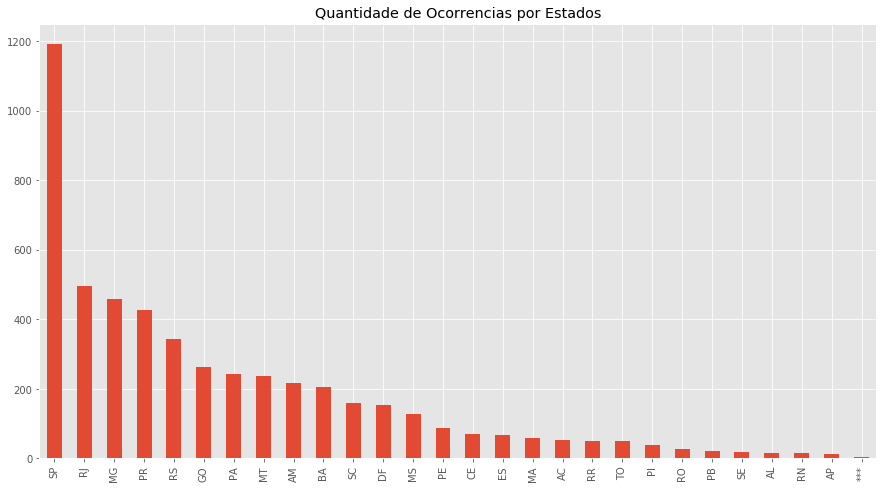

In [0]:
plt.style.use("ggplot")
acidentes_uf_bar = dados_prontos['ocorrencia_uf'].value_counts().plot(kind='bar',
                                                         subplots=True,
                                                         label='Quantidade de Ocorrencias por Estados',
                                                         figsize=(15,8))

## 3. Classificação por Cidades

### Mapa com as Dez Cidades com Maiores Números de Ocorrência

In [0]:
d_incidentes = pd.DataFrame ({
    'fatalidade' : [21, 12, 0, 9, 2, 19, 0, 0, 2, 1],
    'lat' : [-22.9, -23.54, -23.46, -19.81, -15.78, -23.31, -22.9, -30.03, -16.67, -12.97],
    'lon' : [-43.2, -46.63, -46.53, -43.95, -47.93, -51.16, -47.06, -51.23, -49.25, -38.51],
    'cidade' : ['RIO DE JANEIRO', 'SAO PAULO', 'GUARULHOS', 'BELO HORIZONTE', 'BRASILIA', 'LONDRINA',
                'CAMPINAS','PORTO ALEGRE', 'GOIANIA', 'SALVADOR'],
    'regiao' : ['SUDESTE','SUDESTE','SUDESTE','SUDESTE','CENTRO-OESTE', 'SUL', 'SUDESTE', 'SUL',
                'CENTRO-OESTE', 'NORDESTE'],
    'estado' : ['RJ','SP','SP','MG','DF','PR','SP','RS','GO', 'BA'],
    'acidentes' : [239, 202, 137, 133, 123, 100, 96, 78, 76, 75]
    })

d_incidentes

,fatalidade,lat,lon,cidade,regiao,estado,acidentes
0,21,-22.90,-43.20,RIO DE JANEIRO,SUDESTE,RJ,239
1,12,-23.54,-46.63,SAO PAULO,SUDESTE,SP,202
2,0,-23.46,-46.53,GUARULHOS,SUDESTE,SP,137
3,9,-19.81,-43.95,BELO HORIZONTE,SUDESTE,MG,133
4,2,-15.78,-47.93,BRASILIA,CENTRO-OESTE,DF,123
5,19,-23.31,-51.16,LONDRINA,SUL,PR,100
6,0,-22.90,-47.06,CAMPINAS,SUDESTE,SP,96
7,0,-30.03,-51.23,PORTO ALEGRE,SUL,RS,78
8,2,-16.67,-49.25,GOIANIA,CENTRO-OESTE,GO,76
9,1,-12.97,-38.51,SALVADOR,NORDESTE,BA,75


In [0]:
mapa_incidente = folium.Map(location=[-23.54	, -46.63	],
                 zoom_start = 5.4, control_scale = True, prefer_canvas=True)

d_incidentes['acidentes']=d_incidentes.acidentes.astype(float)

for i in range(len(d_incidentes)):
   folium.Circle(
      location=[d_incidentes.iloc[i]['lat'], d_incidentes.iloc[i]['lon']],
      popup="<br>CIDADE: "+d_incidentes.iloc[i]['cidade']+"<br>"+
            "<br>ESTADO: "+d_incidentes.iloc[i]['estado']+"<br>"+
            "<br>REGIAO: "+d_incidentes.iloc[i]['regiao']+"<br>"+
            "<br>QUANTIDADE ACIDENTES: "+str(int(d_incidentes.iloc[i]['acidentes']))+"<br>"+
            "<br>FATALIDADES: " + str(d_incidentes.iloc[i]['fatalidade'])+"<br>",
      radius=d_incidentes.iloc[i]['acidentes']*500,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(mapa_incidente)

mapa_incidente

### Número de Fatalidades nas Cinco Cidades com Maiores Ocorrências

In [0]:
trace_bh = go.Scatter(x=dados_anos['ano'],
                     y=dados_anos['BELO HORIZONTE'],
                     mode = 'lines+markers',
                     name='BELO HORIZONTE',
                     line={'color': '#341f97',
                            'dash': 'dash'})

trace_rj = go.Scatter(x=dados_anos['ano'],
                     y=dados_anos['RIO DE JANEIRO'],
                     mode = 'lines+markers',
                     name='RIO DE JANEIRO',
                     line={'color': '#F15230',
                            'dash': 'dash'})

trace_sp = go.Scatter(x=dados_anos['ano'],
                     y=dados_anos['SAO PAULO'],
                     mode = 'lines+markers',
                     name='SAO PAULO',
                     line={'color': '#F1C40F',
                            'dash': 'dash'})

trace_br = go.Scatter(x=dados_anos['ano'],
                     y=dados_anos['BRASILIA'],
                     mode = 'lines+markers',
                     name='BRASILIA',
                     line={'color': '#F130EE',
                            'dash': 'dash'})

trace_gu = go.Scatter(x=dados_anos['ano'],
                     y=dados_anos['GUARULHOS'],
                     mode = 'lines+markers',
                     name='GUARULHOS',
                     line={'color': '#0C701B',
                            'dash': 'dash'})

data = [trace_bh, trace_rj, trace_sp, trace_br, trace_gu]

layout = go.Layout(title='Número de Fatalidades nas Cinco Cidades com Maiores Ocorrências',
                   yaxis = {'title':'Mortes'},
                   xaxis = {'title':'Anos'})

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

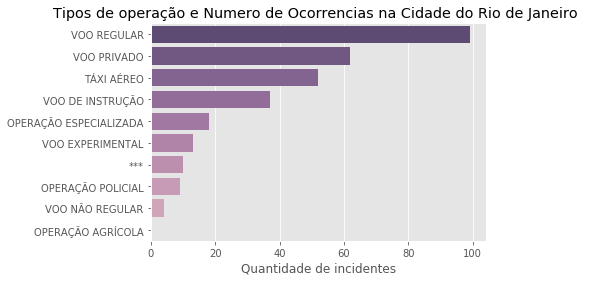

In [0]:
operacao_rj = list(set(dados_prontos['aeronave_tipo_operacao']))
todos_operacao_rj = list(dados_prontos.loc[(dados_prontos['ocorrencia_cidade'])=='RIO DE JANEIRO',
                                           ['aeronave_tipo_operacao']]
                         ['aeronave_tipo_operacao'])

qtd_operacao_rj = pd.DataFrame({'Tipo':operacao_rj, 'Ocorrencia': [todos_operacao_rj.count(i) for i in operacao_rj]})
qtd_operacao_rj = qtd_operacao_rj.sort_values(['Ocorrencia'])

f, ax = plt.subplots()
pallete = sns.cubehelix_palette(10, 3, 0.4, 0.60, 0.8, 0.6)

sns.barplot(qtd_operacao_rj['Ocorrencia'], qtd_operacao_rj['Tipo'], palette=pallete)

ax.invert_yaxis()
ax.set_xlabel('Quantidade de incidentes')
ax.set_ylabel("")
ax.set_title('Tipos de operação e Numero de Ocorrencias na Cidade do Rio de Janeiro ')

plt.show()

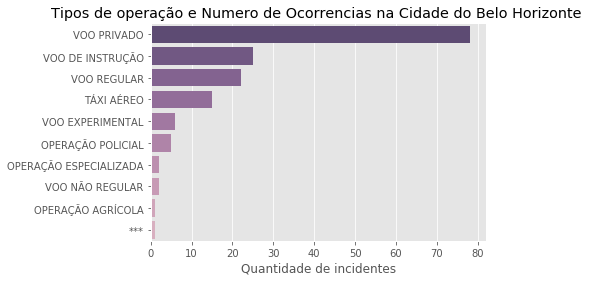

In [0]:
operacao_rj = list(set(dados_prontos['aeronave_tipo_operacao']))
todos_operacao_rj = list(dados_prontos.loc[(dados_prontos['ocorrencia_cidade'])=='BELO HORIZONTE',
                                           ['aeronave_tipo_operacao']]
                         ['aeronave_tipo_operacao'])

qtd_operacao_rj = pd.DataFrame({'Tipo':operacao_rj, 'Ocorrencia': [todos_operacao_rj.count(i) for i in operacao_rj]})
qtd_operacao_rj = qtd_operacao_rj.sort_values(['Ocorrencia'])

f, ax = plt.subplots()
pallete = sns.cubehelix_palette(10, 3, 0.4, 0.60, 0.8, 0.6)

sns.barplot(qtd_operacao_rj['Ocorrencia'], qtd_operacao_rj['Tipo'], palette=pallete)

ax.invert_yaxis()
ax.set_xlabel('Quantidade de incidentes')
ax.set_ylabel("")
ax.set_title('Tipos de operação e Numero de Ocorrencias na Cidade do Belo Horizonte ')

plt.show()

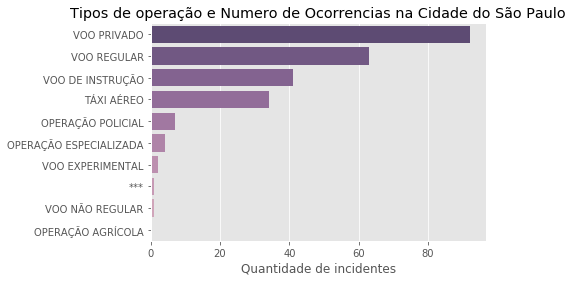

In [0]:
operacao_rj = list(set(dados_prontos['aeronave_tipo_operacao']))
todos_operacao_rj = list(dados_prontos.loc[(dados_prontos['ocorrencia_cidade'])=='SAO PAULO',
                                           ['aeronave_tipo_operacao']]
                         ['aeronave_tipo_operacao'])

qtd_operacao_rj = pd.DataFrame({'Tipo':operacao_rj, 'Ocorrencia': [todos_operacao_rj.count(i) for i in operacao_rj]})
qtd_operacao_rj = qtd_operacao_rj.sort_values(['Ocorrencia'])

f, ax = plt.subplots()
pallete = sns.cubehelix_palette(10, 3, 0.4, 0.60, 0.8, 0.6)

sns.barplot(qtd_operacao_rj['Ocorrencia'], qtd_operacao_rj['Tipo'], palette=pallete)

ax.invert_yaxis()
ax.set_xlabel('Quantidade de incidentes')
ax.set_ylabel("")
ax.set_title('Tipos de operação e Numero de Ocorrencias na Cidade do São Paulo')

plt.show()

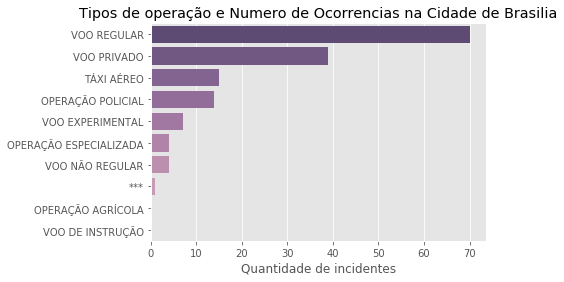

In [0]:
operacao_rj = list(set(dados_prontos['aeronave_tipo_operacao']))
todos_operacao_rj = list(dados_prontos.loc[(dados_prontos['ocorrencia_cidade'])=='BRASILIA',
                                           ['aeronave_tipo_operacao']]
                         ['aeronave_tipo_operacao'])

qtd_operacao_rj = pd.DataFrame({'Tipo':operacao_rj, 'Ocorrencia': [todos_operacao_rj.count(i) for i in operacao_rj]})
qtd_operacao_rj = qtd_operacao_rj.sort_values(['Ocorrencia'])

f, ax = plt.subplots()
pallete = sns.cubehelix_palette(10, 3, 0.4, 0.60, 0.8, 0.6)

sns.barplot(qtd_operacao_rj['Ocorrencia'], qtd_operacao_rj['Tipo'], palette=pallete)

ax.invert_yaxis()
ax.set_xlabel('Quantidade de incidentes')
ax.set_ylabel("")
ax.set_title('Tipos de operação e Numero de Ocorrencias na Cidade de Brasilia')

plt.show()

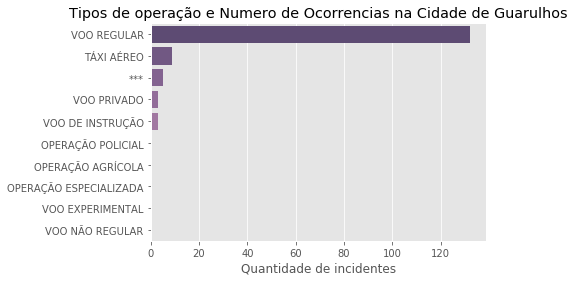

In [0]:
operacao_rj = list(set(dados_prontos['aeronave_tipo_operacao']))
todos_operacao_rj = list(dados_prontos.loc[(dados_prontos['ocorrencia_cidade'])=='GUARULHOS',
                                           ['aeronave_tipo_operacao']]
                         ['aeronave_tipo_operacao'])

qtd_operacao_rj = pd.DataFrame({'Tipo':operacao_rj, 'Ocorrencia': [todos_operacao_rj.count(i) for i in operacao_rj]})
qtd_operacao_rj = qtd_operacao_rj.sort_values(['Ocorrencia'])

f, ax = plt.subplots()
pallete = sns.cubehelix_palette(10, 3, 0.4, 0.60, 0.8, 0.6)

sns.barplot(qtd_operacao_rj['Ocorrencia'], qtd_operacao_rj['Tipo'], palette=pallete)

ax.invert_yaxis()
ax.set_xlabel('Quantidade de incidentes')
ax.set_ylabel("")
ax.set_title('Tipos de operação e Numero de Ocorrencias na Cidade de Guarulhos')

plt.show()